In [ ]:
!pip install optuna
!pip install xgboost
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Challenge/DACON/2024 Samsung AI Challenge : Black-box Optimization/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Challenge/DACON/2024 Samsung AI Challenge : Black-box Optimization/test.csv")

In [ ]:
columns = train.columns

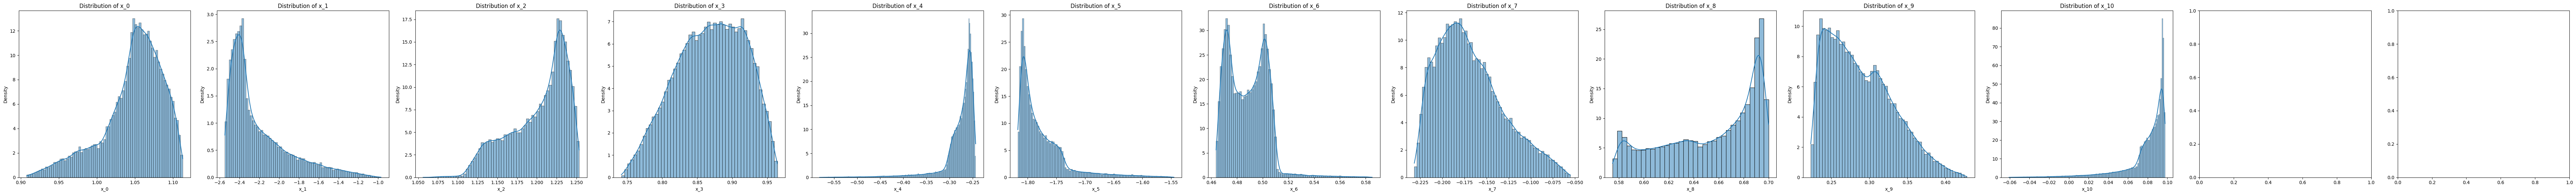

In [ ]:
n_cols = len(columns)
figure, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(6*n_cols, 6))

for i, col in enumerate(columns[1:-1]):
    sns.histplot(train[col], kde=True, ax=axes[i], stat="density")
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

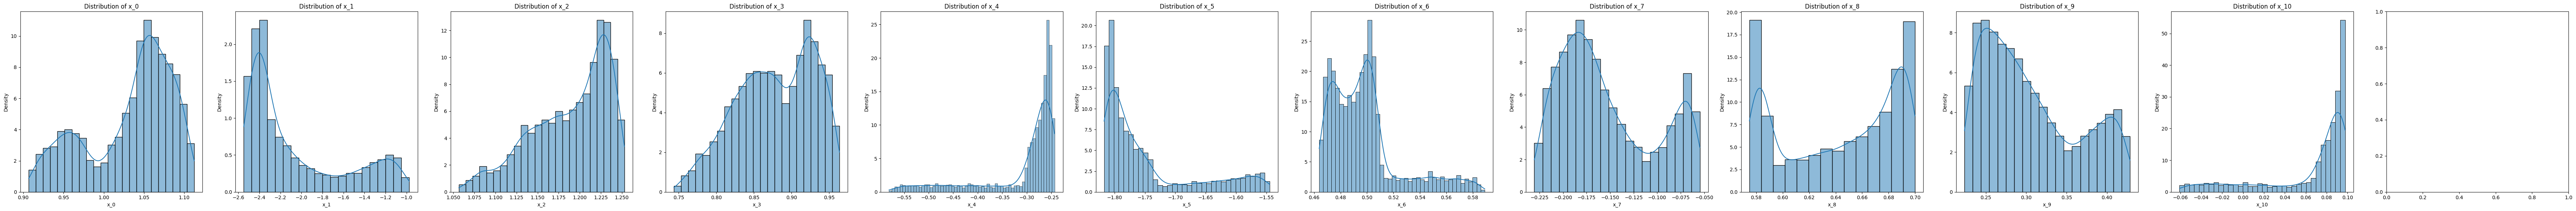

In [ ]:
test_cols =test.columns
n_cols = len(test_cols)
figure, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(6*n_cols, 6))

for i, col in enumerate(test_cols[1:]):
    sns.histplot(test[col], kde=True, ax=axes[i], stat="density")
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [ ]:
for col in train.columns[1:-1]:
    min_value = train[col].min()
    max_value = train[col].max()

    train[col] = ((train[col] - min_value) / (max_value - min_value)) + 1e-6


for col in test.columns[1:]:
    min_value = test[col].min()
    max_value = test[col].max()

    test[col] = ((test[col] - min_value) / (max_value - min_value)) + 1e-6

In [ ]:
train = train.drop(train[train['y'] < 70].index)

In [ ]:
from scipy.stats import skew

for col in cols:
    skewness = skew(train[col])
    print(f'Skewness of {col}: {skewness}')
print("-------------------------------")
for col in cols:
    skewness = skew(test[col])
    print(f'Skewness of {col}: {skewness}')

Skewness of x_0: -0.9549191283456623
Skewness of x_1: 1.3749859965190234
Skewness of x_2: -0.7696274752766838
Skewness of x_3: -0.22595357792042695
Skewness of x_4: -3.302469060927062
Skewness of x_5: 2.1671422070984074
Skewness of x_6: 0.8898377583576672
Skewness of x_7: 0.6552798246431991
Skewness of x_8: -0.5486859143307468
Skewness of x_9: 0.6109953625461525
Skewness of x_10: -2.4513112303385833
-------------------------------
Skewness of x_0: -0.6986048542818546
Skewness of x_1: 0.9570021757588574
Skewness of x_2: -0.7063502404246221
Skewness of x_3: -0.33453303065713413
Skewness of x_4: -1.6888250702237186
Skewness of x_5: 1.3005385144606254
Skewness of x_6: 1.3908747799489298
Skewness of x_7: 0.5675171636649347
Skewness of x_8: -0.3001150429821735
Skewness of x_9: 0.5880521978972802
Skewness of x_10: -1.4236448735923004


In [ ]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

for col in ['x_1', 'x_5', 'x_6']:
    train[col] = np.log1p(train[col])  # log1p: log(1 + x)로 0을 처리 가능
    test[col] = np.log1p(test[col])

pt = PowerTransformer(method='yeo-johnson')
train['x_4'] = pt.fit_transform(train[['x_4']])
test['x_4'] = pt.transform(test[['x_4']])

train['x_10'] = pt.fit_transform(train[['x_10']])
test['x_10'] = pt.transform(test[['x_10']])

for col in ['x_0', 'x_2', 'x_3', 'x_7', 'x_8', 'x_9']:
    train[col] = np.sqrt(train[col])  # 제곱근 변환 적용
    test[col] = np.sqrt(test[col])

In [ ]:
from scipy.stats import skew

for col in cols:
    skewness = skew(train[col])
    print(f'Skewness of {col}: {skewness}')
print("-------------------------------")
for col in cols:
    skewness = skew(test[col])
    print(f'Skewness of {col}: {skewness}')

Skewness of x_0: -1.6112989511740021
Skewness of x_1: 1.0886887243101682
Skewness of x_2: -1.0704891239392589
Skewness of x_3: -0.7433538932364568
Skewness of x_4: -0.46263624361511135
Skewness of x_5: 1.7003995583621172
Skewness of x_6: 0.4559721891620348
Skewness of x_7: -0.008290849127760755
Skewness of x_8: -0.9979723943571416
Skewness of x_9: -0.029199943728705387
Skewness of x_10: -0.522347930636934
-------------------------------
Skewness of x_0: -1.1540133854683476
Skewness of x_1: 0.7915689176829658
Skewness of x_2: -1.2744994954175908
Skewness of x_3: -0.8460117260690427
Skewness of x_4: -0.28168795054474804
Skewness of x_5: 1.1138205108152168
Skewness of x_6: 1.0004406084338722
Skewness of x_7: 0.06035399845996768
Skewness of x_8: -0.6211735695428322
Skewness of x_9: 0.06014696347369447
Skewness of x_10: -0.31974968927645103


In [ ]:
for col in train.columns[1:-1]:
    sq_col = col +"_squared"
    c_col = col + "_cubed"
    train[sq_col] = train[col] ** 2
    train[c_col] = train[col] ** 3
    if col == 'y':
        continue
    test[sq_col] = test[col] ** 2
    test[c_col] = test[col] ** 3

In [ ]:
correlations = {}
for col in train.columns[1:]:
    if col != 'y':
        correlations[col] = train[col].corr(train['y'])


low_corr = []

for key, value in correlations.items():
    if value < 0.5:
        low_corr.append(key)
    print(f'Correlation between {key} and {"y"}: {value:.4f}')



Correlation between x_0 and y: -0.6617
Correlation between x_1 and y: 0.7492
Correlation between x_2 and y: 0.1032
Correlation between x_3 and y: 0.5528
Correlation between x_4 and y: -0.4289
Correlation between x_5 and y: 0.6001
Correlation between x_6 and y: -0.0502
Correlation between x_7 and y: 0.6896
Correlation between x_8 and y: -0.7610
Correlation between x_9 and y: 0.6831
Correlation between x_10 and y: -0.6080


In [ ]:
x_train = train.drop(columns=['ID', 'y','x_2','x_6'])
y_train = train['y']
x_test = test.drop(columns=['ID','x_2','x_6'])

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler_X = RobustScaler()

scaler_Y = RobustScaler()

x_train = scaler_X.fit_transform(x_train)

y_train = y_train.values.reshape(-1, 1)
y_train = scaler_Y.fit_transform(y_train)

x_test = scaler_X.transform(x_test)

In [ ]:
x_test[0]

array([-0.29875783,  0.52480258,  0.34319696,  0.37196853,  0.54276173,
        0.46381058, -0.28473793, -0.27061257,  0.34866512,  0.35402411,
       -0.21949659,  0.38635823,  0.39875116,  0.55464182,  0.56239451,
        0.48081937,  0.49709984, -0.56861013])

In [ ]:
model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15,
                                         min_samples_split=10, loss='huber', random_state=18)

model_XGB=XGBRegressor(colsample_bylevel=0.9229733609038979,colsample_bynode=0.21481791874780318,colsample_bytree=0.607964318297635,
                       gamma=0.8989889254961725, learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602,
                       reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
                       tree_method='gpu_hist',verbosity=0)

In [ ]:
y_train.min()

72.3173828125

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Challenge/DACON/2024 Samsung AI Challenge : Black-box Optimization/sample_submission.csv")


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

def top_percent_recall(y_true, y_pred):
    df_true = pd.DataFrame(y_true, columns=['true'])
    df_pred = pd.DataFrame(y_pred, columns=['pred'])

    df_true['true_rank'] = df_true['true'].rank(ascending=False, method='first')
    df_pred['pred_rank'] = df_pred['pred'].rank(ascending=False, method='first')

    top_5_threshold = np.percentile(df_true['true'], 95)
    top_10_threshold = np.percentile(df_pred['pred'], 90)

    top_5_mask = df_true['true'] >= top_5_threshold
    top_10_mask = df_pred['pred'] >= top_10_threshold

    intersection = np.sum(top_5_mask & top_10_mask)
    recall = intersection / np.sum(top_5_mask) if np.sum(top_5_mask) > 0 else 0

    return recall

top_recall_scorer = make_scorer(top_percent_recall, greater_is_better=True)

Xtrain = x_train
Ytrain = y_train.ravel()
Xtest = x_test

model_Lasso = make_pipeline(StandardScaler(), Lasso(max_iter=10000, random_state=18))
lasso_params = {'lasso__alpha': [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]}
random_search_lasso = RandomizedSearchCV(model_Lasso, lasso_params, cv=5, scoring=top_recall_scorer, n_iter=10, random_state=18)
random_search_lasso.fit(Xtrain, Ytrain)
Lasso_best = random_search_lasso.best_estimator_

model_ENet = make_pipeline(StandardScaler(), ElasticNet(random_state=18))
enet_params = {'elasticnet__alpha': [0.1, 0.005, 0.0001], 'elasticnet__l1_ratio': [0.1, 0.5, 0.9]}
random_search_enet = RandomizedSearchCV(model_ENet, enet_params, cv=5, scoring=top_recall_scorer, n_iter=50, random_state=18)
random_search_enet.fit(Xtrain, Ytrain)
ENet_best = random_search_enet.best_estimator_

model_GBoost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.001, max_depth=5,
                                         max_features='sqrt', min_samples_leaf=25, min_samples_split=15,
                                         loss='squared_error', random_state=18)
model_GBoost.fit(Xtrain, Ytrain)

model_XGB = XGBRegressor(colsample_bylevel=0.9229733609038979, colsample_bynode=0.21481791874780318,
                         colsample_bytree=0.607964318297635, gamma=0.8989889254961725, learning_rate=0.009192310189734834,
                         max_depth=3, n_estimators=2500, reg_alpha=3.185674564163364e-12,
                         reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
                         tree_method='hist', verbosity=0)
model_XGB.fit(Xtrain, Ytrain)

train_Lasso = Lasso_best.predict(Xtrain)
train_ENet = ENet_best.predict(Xtrain)
train_XGB = model_XGB.predict(Xtrain)
train_GBoost = model_GBoost.predict(Xtrain)

weights = [0.25, 0.25, 0.25, 0.25]  # 가중치 설정
log_train_predictions = (train_Lasso * weights[0] + train_ENet * weights[1] +
                         train_XGB * weights[2] + train_GBoost * weights[3])

train_score = top_percent_recall(Ytrain, log_train_predictions)
print(f"Scoring with train data (Top 5% recall): {train_score}")

Lasso_predictions = Lasso_best.predict(Xtest)
ENet_predictions = ENet_best.predict(Xtest)
XGB_predictions = model_XGB.predict(Xtest)
GBoost_predictions = model_GBoost.predict(Xtest)

log_predictions = (Lasso_predictions * weights[0] + ENet_predictions * weights[1] +
                   XGB_predictions * weights[2] + GBoost_predictions * weights[3])



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scoring with train data (Top 5% recall): 0.8838484546360917


In [ ]:
predictions = np.exp(log_predictions) - 1

submission['y']= predictions
submission.to_csv('Result.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

def top_percent_recall(y_true, y_pred):
    df_true = pd.DataFrame(y_true, columns=['true'])
    df_pred = pd.DataFrame(y_pred, columns=['pred'])

    df_true['true_rank'] = df_true['true'].rank(ascending=False, method='first')
    df_pred['pred_rank'] = df_pred['pred'].rank(ascending=False, method='first')

    top_5_threshold = np.percentile(df_true['true'], 95)
    top_10_threshold = np.percentile(df_pred['pred'], 90)

    top_5_mask = df_true['true'] >= top_5_threshold
    top_10_mask = df_pred['pred'] >= top_10_threshold

    intersection = np.sum(top_5_mask & top_10_mask)

    recall = intersection / np.sum(top_5_mask) if np.sum(top_5_mask) > 0 else 0

    return recall


In [ ]:
log_train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost) / 4

0.8808574277168495
0.8808574277168495
0.8833499501495513
0.8888334995014955
0.8838484546360917


In [ ]:
submission

,y
0,0.129778
1,-0.326617
2,16.799713
3,22.529373
4,-0.360669
...,...
4981,0.045484
4982,25.531748
4983,-0.162404
4984,-0.186570


In [ ]:
submission1 = pd.read_csv("/content/drive/MyDrive/Challenge/DACON/2024 Samsung AI Challenge : Black-box Optimization/sample_submission.csv")
submission1['y'] = submission['y']

In [ ]:
submission1.to_csv('Result.csv', index=False)